Required imports

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, TensorDataset
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
from keras.datasets import mnist 
import tensorflow as tf
import matplotlib.pyplot as plt


Splitting the data sets 

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# combining test and training sets 
x_all = np.concatenate((x_train, x_test), axis=0)
y_all = np.concatenate((y_train, y_test), axis=0)

# shuffling them to avoid bias 
indices = np.arange(x_all.shape[0])
np.random.seed(42)  # For reproducibility
np.random.shuffle(indices)
x_all = x_all[indices]
y_all = y_all[indices]
#split training and temp 
x_train, x_temp, y_train, y_temp = train_test_split(
    x_all, y_all, test_size=0.4, random_state=42
)

# split temp to test and validation sets 
x_val, x_test, y_val, y_test = train_test_split(
    x_temp, y_temp, test_size=0.5, random_state=42
)
#converting images to vectors and normalising pixel value
x_train = x_train.reshape(-1, 28*28).astype('float32') / 255.0
x_val = x_val.reshape(-1, 28*28).astype('float32') / 255.0
x_test = x_test.reshape(-1, 28*28).astype('float32') / 255.0
# Verify the splits
print(f"Training set: {x_train.shape}, {y_train.shape}")
print(f"Validation set: {x_val.shape}, {y_val.shape}")
print(f"Test set: {x_test.shape}, {y_test.shape}")

Training set: (42000, 784), (42000,)
Validation set: (14000, 784), (14000,)
Test set: (14000, 784), (14000,)


Creating global variables to store training and calling compare models

In [12]:
global history_no_dropout 
global history_with_dropout 
history_no_dropout = {}
history_with_dropout = {}

compare_models(x_train, y_train)


Testing model 1/4
Training with 2 layers - no dropout
Training with 2 layers - with dropout


c:\Users\DELL\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\reshaping\reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Testing model 2/4
Training with 3 layers - no dropout
Training with 3 layers - with dropout

Testing model 3/4
Training with 4 layers - no dropout
Training with 4 layers - with dropout

Testing model 4/4
Training with 5 layers - no dropout
Training with 5 layers - with dropout

Testing with 16 nodes

Testing with 32 nodes

Testing with 64 nodes

Testing with 128 nodes

Testing learning rate 0.1

Testing learning rate 0.01

Testing learning rate 0.05

Testing learning rate 0.005

Testing batch size 16

Testing batch size 32

Testing batch size 64

Testing batch size 128

Best performing models based on validation accuracy:
Without Dropout: lr_0.1 - Accuracy: 0.9713
With Dropout: nodes_128 - Accuracy: 0.9859


Creating Models

In [3]:
def create_model(input_shape, num_layers, num_nodes, dropout_prob, use_dropout,lr):
    nn_model = tf.keras.Sequential()
    
    # If dropout is used, add a Conv2D layer
    if use_dropout:
        nn_model.add(tf.keras.layers.Reshape((28, 28, 1), input_shape=input_shape)) #reshaping back to 28x28x1
        nn_model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu'))#feature extraction
        nn_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2))) #reducing size by taking max in window
    #convert multi features to 1d vector
    nn_model.add(tf.keras.layers.Flatten()) 
    nn_model.add(tf.keras.layers.Dense(num_nodes, activation='relu'))
    
    for i in range(num_layers - 1):
        nn_model.add(tf.keras.layers.Dense(num_nodes, activation='relu'))
        if use_dropout:
            nn_model.add(tf.keras.layers.Dropout(dropout_prob))
            nn_model.add(tf.keras.layers.LayerNormalization())
    
    # 10 output nodes with softmax for MNIST
    nn_model.add(tf.keras.layers.Dense(10, activation='softmax'))
    
    nn_model.compile(
        optimizer=tf.keras.optimizers.SGD(learning_rate=lr), #uses random batches of data 
        loss='sparse_categorical_crossentropy',  
        metrics=['accuracy']
    )
    
    return nn_model

Model training 

In [11]:
def train_model(X_train, y_train, num_layers, num_nodes, dropout_prob, lr, batch_size, use_dropout):
    nn_model = create_model(
        input_shape=(X_train.shape[1],), 
        num_layers=num_layers, 
        num_nodes=num_nodes, 
        dropout_prob=dropout_prob, 
        use_dropout=use_dropout,
        lr=lr
    )
    
    history = nn_model.fit(
        X_train, y_train,
        batch_size=batch_size,
        epochs=10,
        validation_data=(x_val, y_val),
        verbose=0
    )
    
    return history

Calling Plot

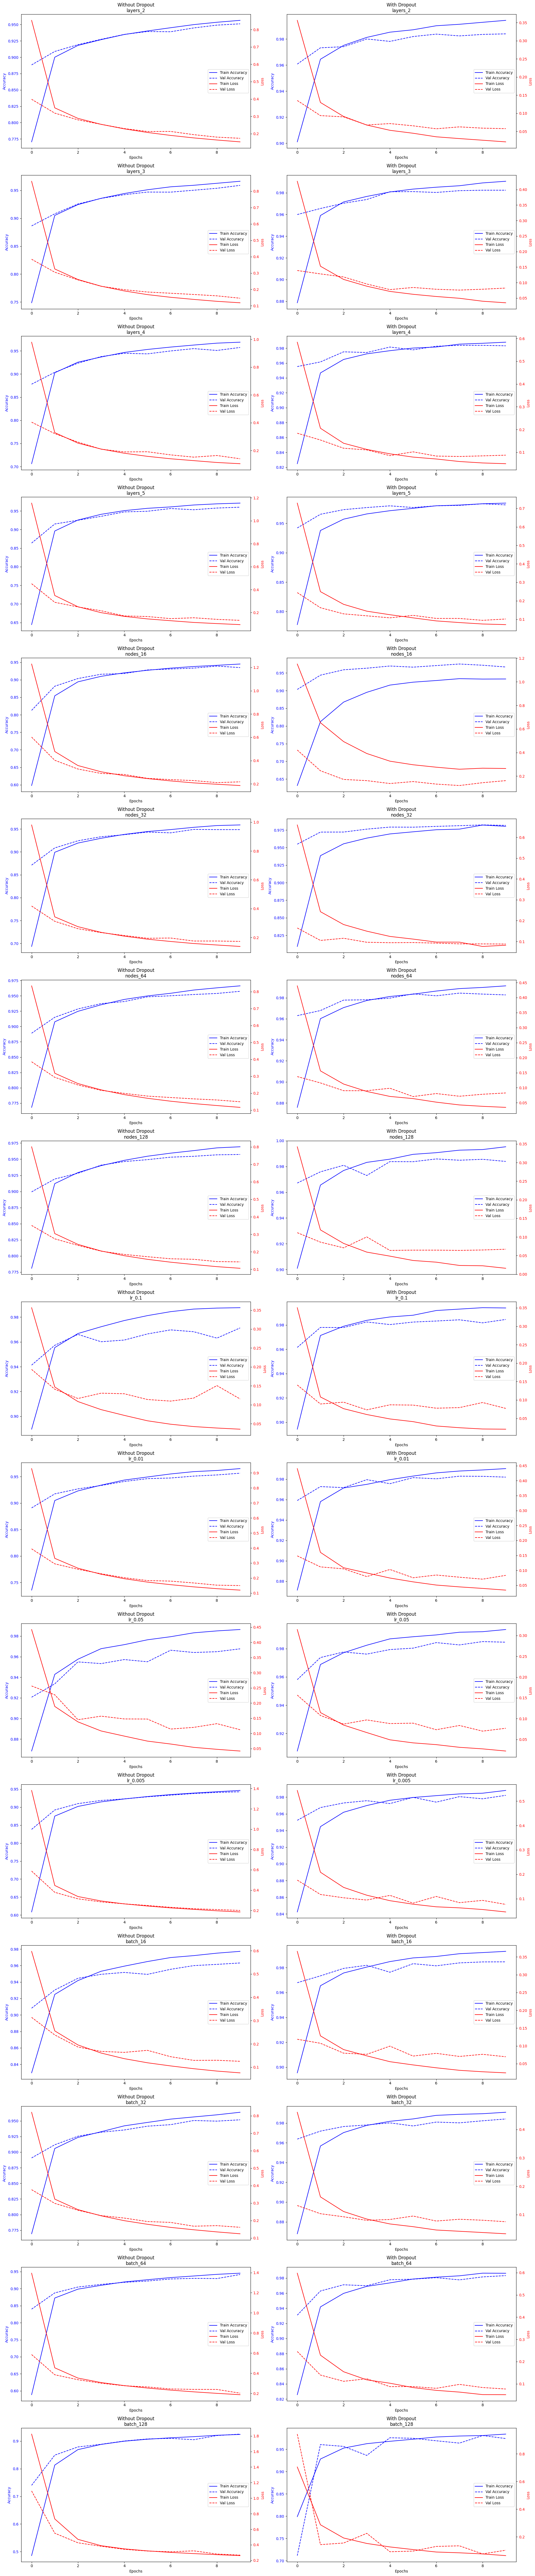


Best performing models based on validation accuracy:
Without Dropout: lr_0.1
Best validation accuracy: 0.9713
Final validation loss: 0.1098

With Dropout: nodes_128
Best validation accuracy: 0.9859
Final validation loss: 0.0639


In [13]:
plot_results(history_no_dropout, history_with_dropout)

Calling confusion matrix plot


438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Configuration: layers_2

Without Dropout:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      1429
           1       0.97      0.98      0.97      1548
           2       0.96      0.95      0.95      1421
           3       0.93      0.94      0.93      1384
           4       0.96      0.93      0.94      1373
           5       0.95      0.90      0.93      1246
           6       0.95      0.96      0.96      1318
           7       0.96      0.96      0.96      1493
           8       0.94      0.93      0.93      1368
           9       0.90      0.95      0.93      1420

    accuracy                           0.95     14000
   macro avg       0.95      0.95      0.95     14000
weighted avg       0.95      0.95      0.95     14000


With Dropout:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99   

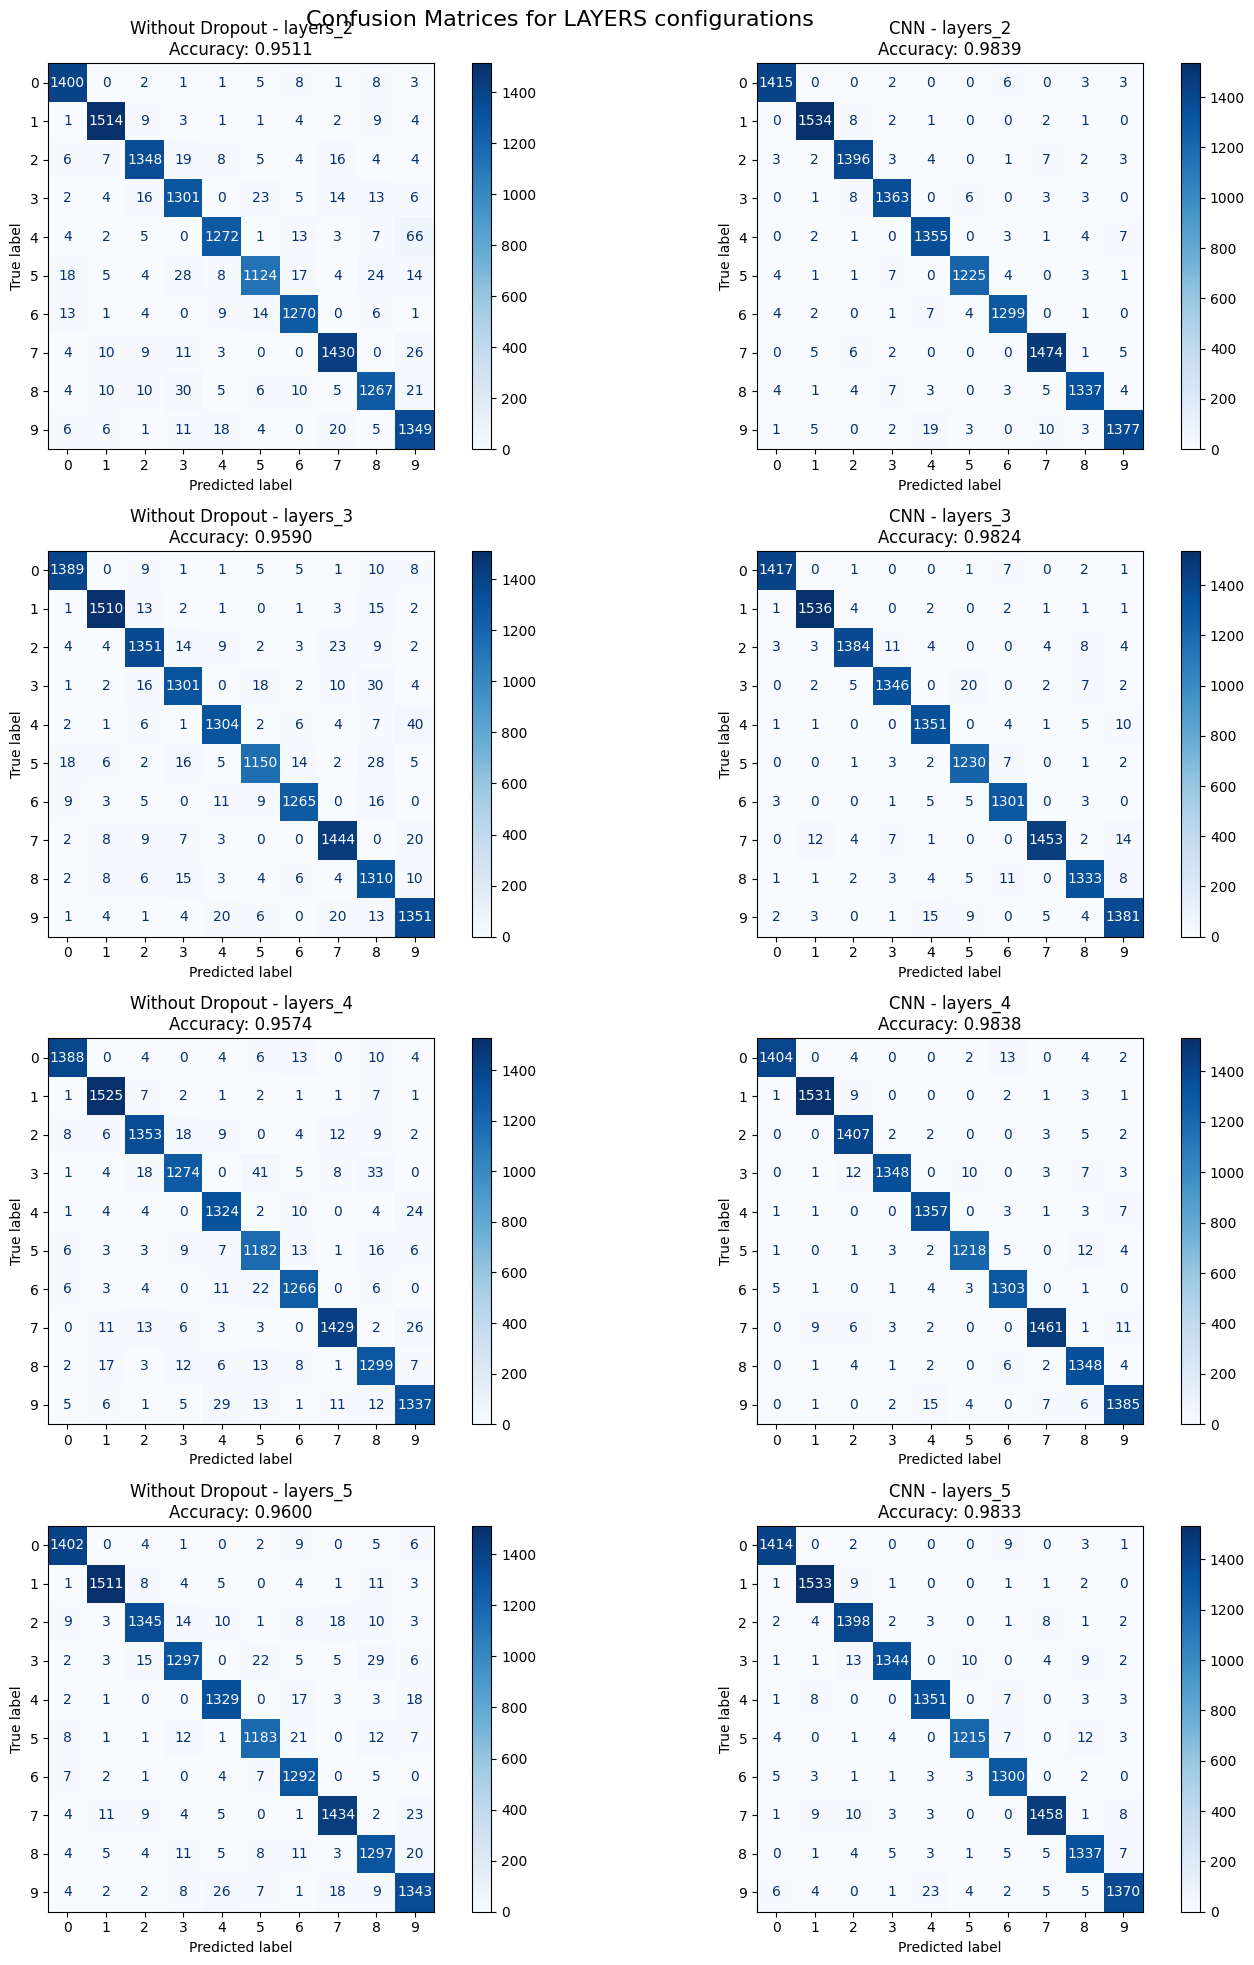

438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

Configuration: nodes_16

Without Dropout:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      1429
           1       0.96      0.97      0.97      1548
           2       0.97      0.86      0.91      1421
           3       0.87      0.93      0.90      1384
           4       0.91      0.94      0.93      1373
           5       0.88      0.92      0.90      1246
           6       0.96      0.95      0.95      1318
           7       0.92      0.96      0.94      1493
           8       0.94      0.87      0.90      1368
           9       0.92      0.91      0.91      1420

    accuracy                           0.93     14000
   macro avg       0.93      0.93      0.93     14000
weighted avg       0.93      0.93      0.93     14000


With Dropout:
              precision    recall  f1-score   support

           0       0.99      0.98      0.98   

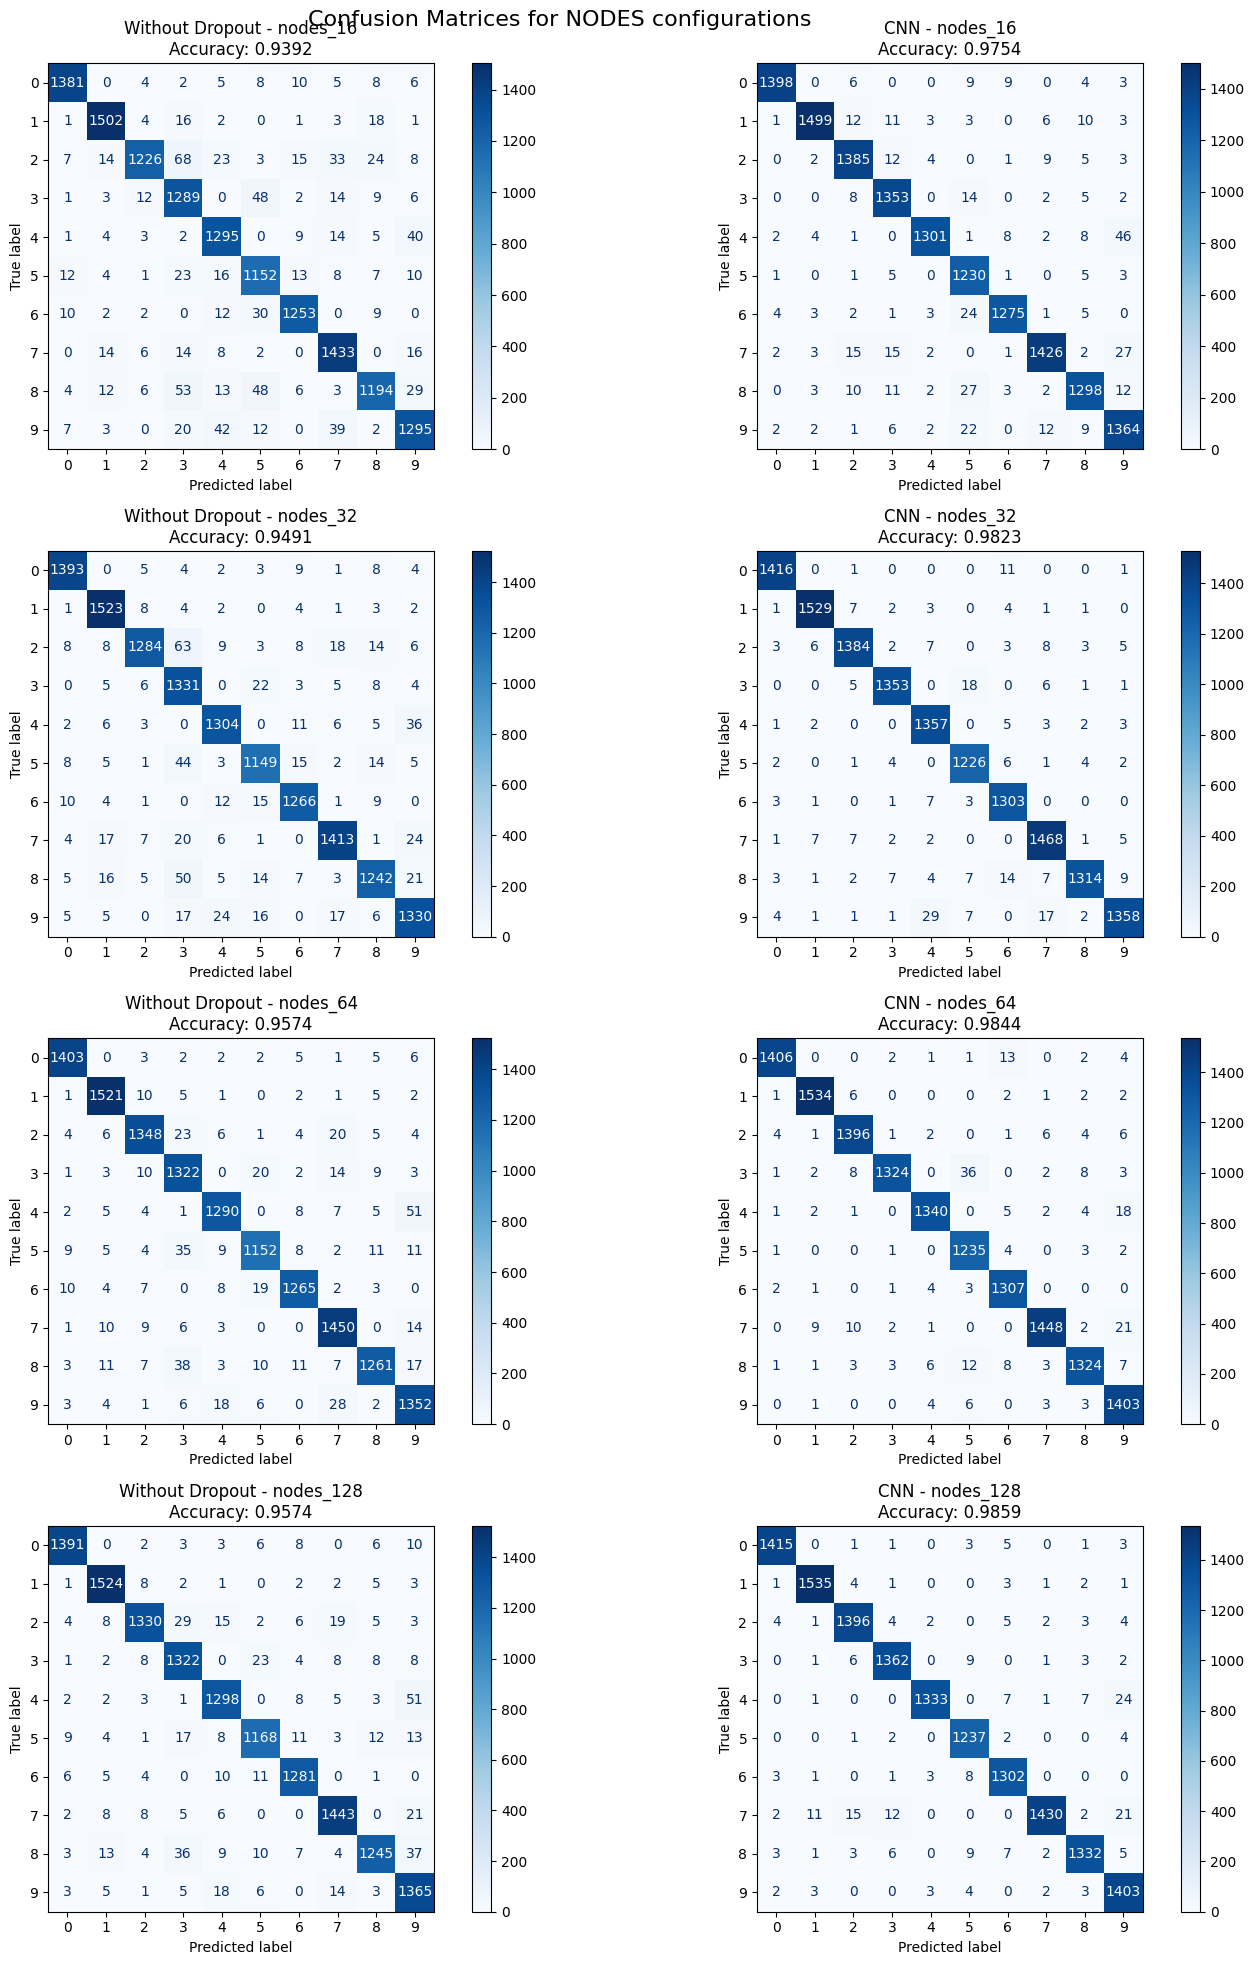

438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

Configuration: lr_0.1

Without Dropout:
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      1429
           1       0.99      0.98      0.98      1548
           2       0.97      0.97      0.97      1421
           3       0.94      0.97      0.95      1384
           4       0.98      0.96      0.97      1373
           5       0.97      0.94      0.96      1246
           6       0.97      0.98      0.97      1318
           7       0.98      0.97      0.97      1493
           8       0.94      0.97      0.96      1368
           9       0.96      0.96      0.96      1420

    accuracy                           0.97     14000
   macro avg       0.97      0.97      0.97     14000
weighted avg       0.97      0.97      0.97     14000


With Dropout:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     

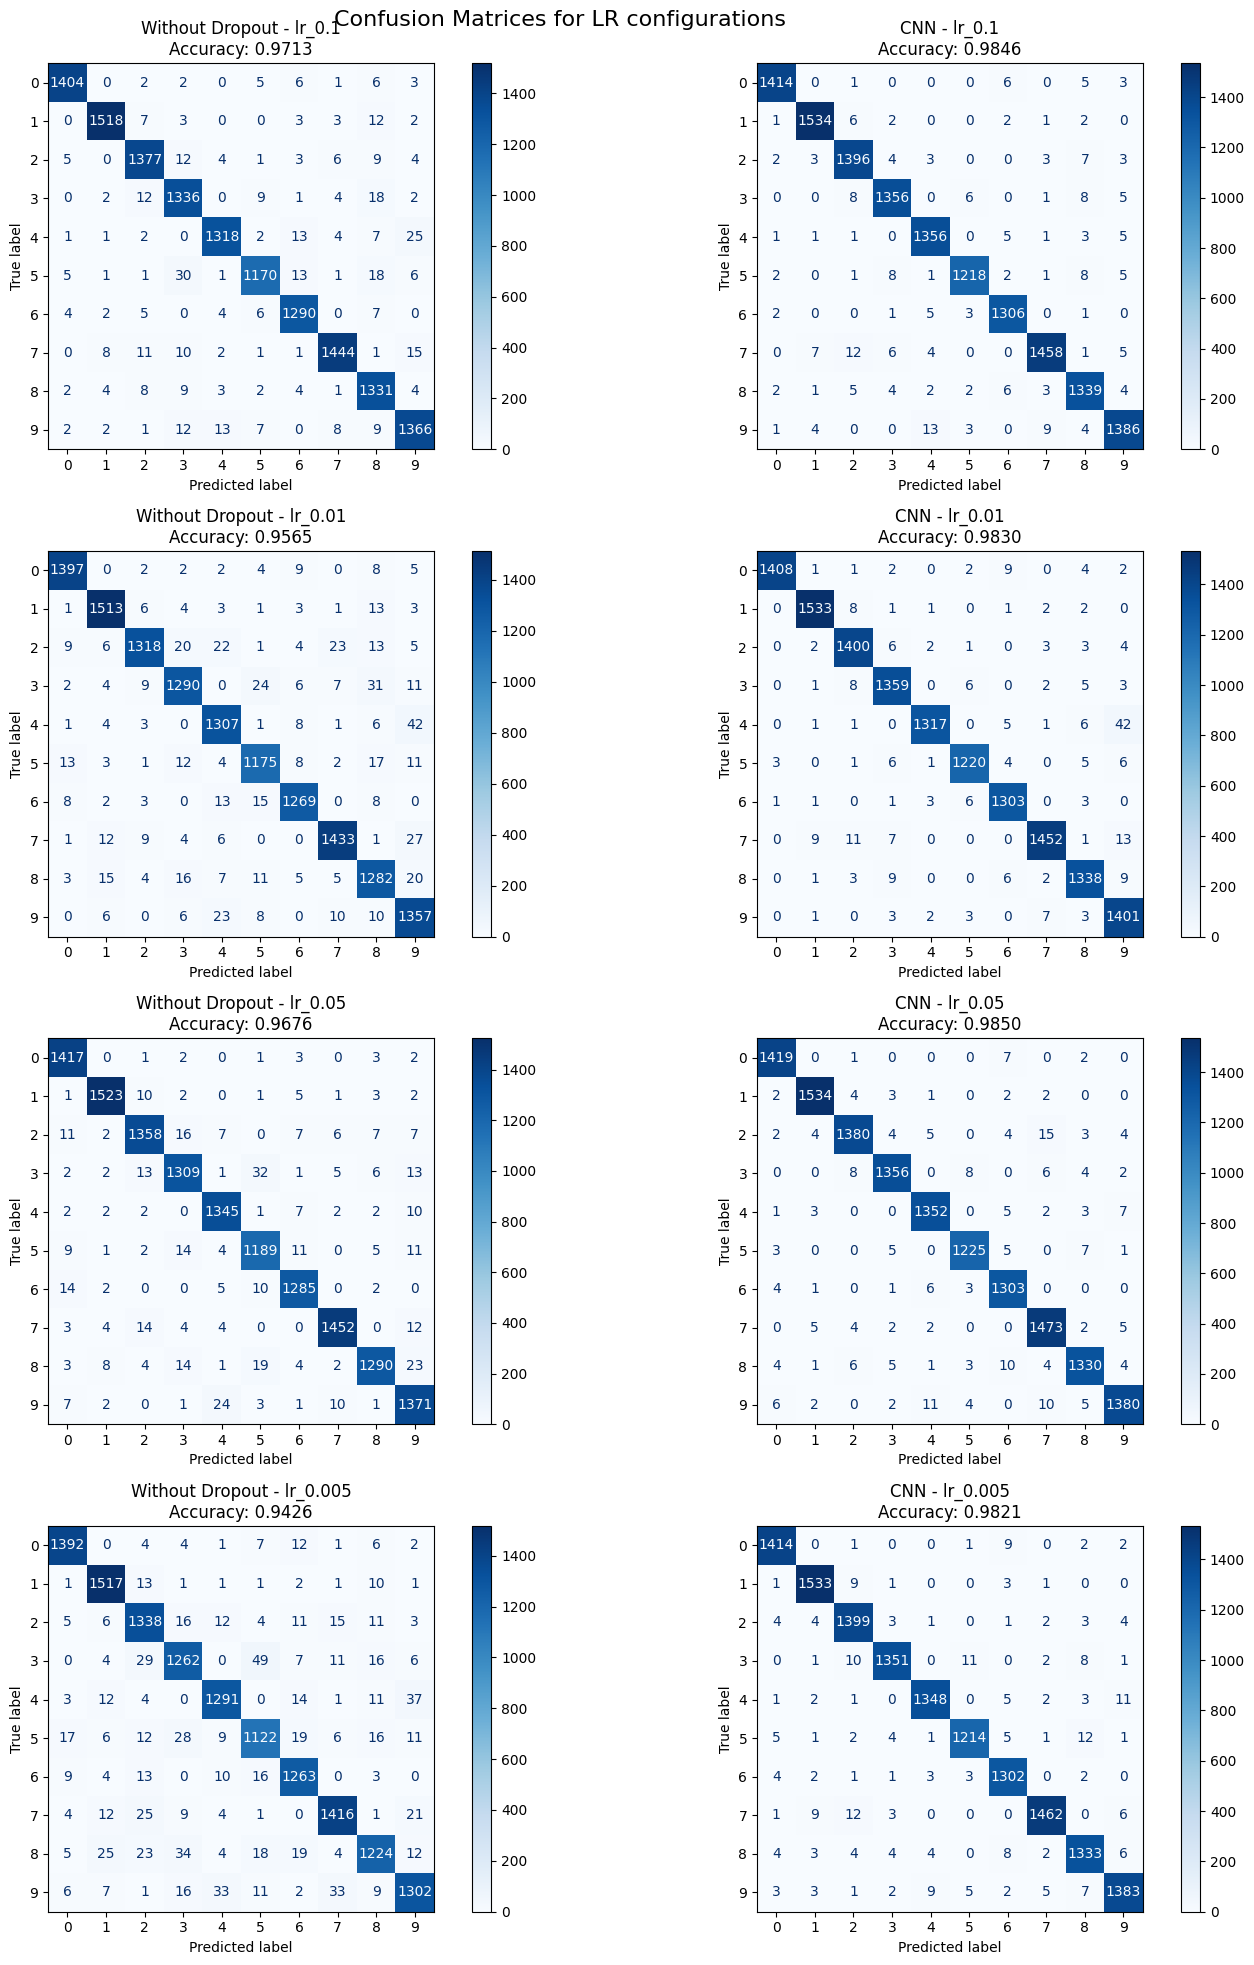

438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Configuration: batch_16

Without Dropout:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1429
           1       0.96      0.99      0.97      1548
           2       0.96      0.97      0.96      1421
           3       0.96      0.95      0.95      1384
           4       0.97      0.95      0.96      1373
           5       0.98      0.93      0.95      1246
           6       0.97      0.98      0.97      1318
           7       0.96      0.97      0.97      1493
           8       0.95      0.95      0.95      1368
           9       0.95      0.95      0.95      1420

    accuracy                           0.96     14000
   macro avg       0.96      0.96      0.96     14000
weighted avg       0.96      0.96      0.96     14000


With Dropout:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99 

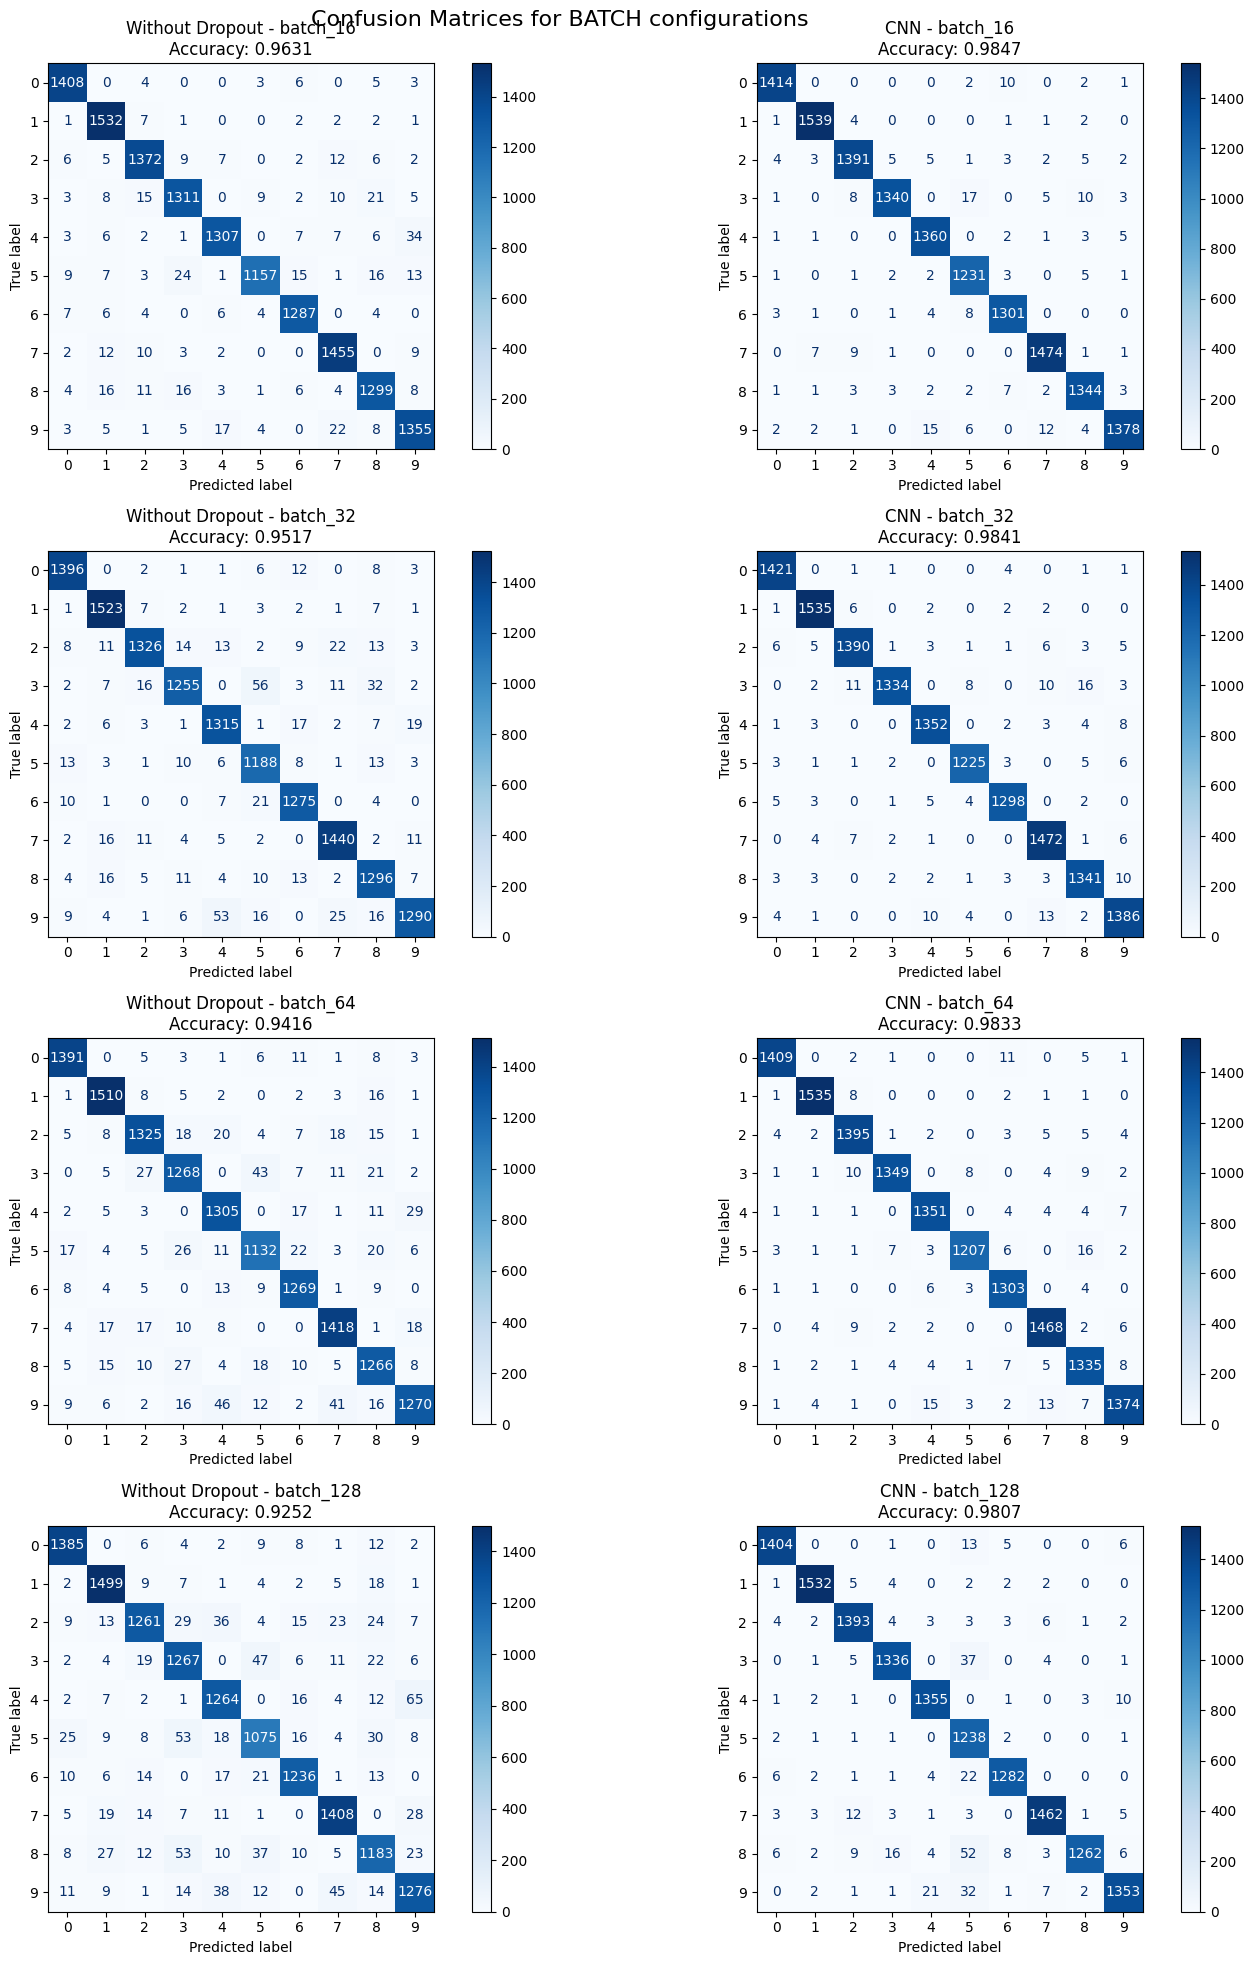

In [16]:
plot_confusion_matrices(x_test, y_test, history_no_dropout, history_with_dropout)

Plot results function

In [7]:
def plot_results(history_no_dropout, history_with_dropout):
     # Create figure
    num_models = len(history_no_dropout)  
    fig, axes = plt.subplots(num_models, 2, figsize=(20, 6 * num_models))
    if num_models == 1:
        axes = axes.reshape(1, 2)
    
    # Plot models side by side
    for idx, ((config_no_drop, history_no_drop), (config_drop, history_drop)) in \
        enumerate(zip(history_no_dropout.items(), history_with_dropout.items())): #pair up models and index them
        
        # Plot No Dropout (left side)
        ax1 = axes[idx, 0]
        ax1_twin = ax1.twinx() #twin axis for accuracy and loss
        
        # Accuracy on left y-axis
        color1 = 'blue'
        line1, = ax1.plot(history_no_drop.history['accuracy'], color=color1, 
                         linestyle='-', label='Train Accuracy')
        line2, = ax1.plot(history_no_drop.history['val_accuracy'], color=color1, 
                         linestyle='--', label='Val Accuracy')
        ax1.set_ylabel('Accuracy', color=color1)
        ax1.tick_params(axis='y', labelcolor=color1)
        
        # Loss on right y-axis
        color2 = 'red'
        line3, = ax1_twin.plot(history_no_drop.history['loss'], color=color2, 
                              linestyle='-', label='Train Loss')
        line4, = ax1_twin.plot(history_no_drop.history['val_loss'], color=color2, 
                              linestyle='--', label='Val Loss')
        ax1_twin.set_ylabel('Loss', color=color2)
        ax1_twin.tick_params(axis='y', labelcolor=color2)
        
        ax1.set_title(f'Without Dropout\n{config_no_drop}')
        ax1.set_xlabel('Epochs')
        
        # Combine plots
        lines = [line1, line2, line3, line4]
        labels = [l.get_label() for l in lines]
        ax1.legend(lines, labels, loc='center right')
        
        # Plot With Dropout (right side)
        ax2 = axes[idx, 1]
        ax2_twin = ax2.twinx()
        
        # Accuracy on left y-axis
        line1, = ax2.plot(history_drop.history['accuracy'], color=color1, 
                         linestyle='-', label='Train Accuracy')
        line2, = ax2.plot(history_drop.history['val_accuracy'], color=color1, 
                         linestyle='--', label='Val Accuracy')
        ax2.set_ylabel('Accuracy', color=color1)
        ax2.tick_params(axis='y', labelcolor=color1)
        
        # Loss on right y-axis
        line3, = ax2_twin.plot(history_drop.history['loss'], color=color2, 
                              linestyle='-', label='Train Loss')
        line4, = ax2_twin.plot(history_drop.history['val_loss'], color=color2, 
                              linestyle='--', label='Val Loss')
        ax2_twin.set_ylabel('Loss', color=color2)
        ax2_twin.tick_params(axis='y', labelcolor=color2)
        
        ax2.set_title(f'With Dropout\n{config_drop}')
        ax2.set_xlabel('Epochs')
        
        # Combine legends
        lines = [line1, line2, line3, line4]
        labels = [l.get_label() for l in lines]
        ax2.legend(lines, labels, loc='center right')
    
    plt.tight_layout()
    plt.show()
    
    # Print best performing models
    print("\nBest performing models based on validation accuracy:")
    best_no_dropout = max(history_no_dropout.items(), 
                         key=lambda x: max(x[1].history['val_accuracy'])) #x[1] is the history of the model
    print(f"Without Dropout: {best_no_dropout[0]}")
    print(f"Best validation accuracy: {max(best_no_dropout[1].history['val_accuracy']):.4f}")
    print(f"Final validation loss: {min(best_no_dropout[1].history['val_loss']):.4f}")
    
    best_with_dropout = max(history_with_dropout.items(), 
                           key=lambda x: max(x[1].history['val_accuracy']))
    print(f"\nWith Dropout: {best_with_dropout[0]}")
    print(f"Best validation accuracy: {max(best_with_dropout[1].history['val_accuracy']):.4f}")
    print(f"Final validation loss: {min(best_with_dropout[1].history['val_loss']):.4f}")

Comparing CNN and NN 

In [ ]:
def compare_models(X_train, y_train):
    num_layers_list = [2,3,4,5]          
    num_nodes_list = [16, 32, 64, 128]   
    lr_list = [0.1, 0.01, 0.05, 0.005]   
    batch_size_list = [16, 32, 64, 128]  
    
    # Counter for tracking progress
    total_models = len(num_layers_list)  
    current_model = 0 #counter
    
    # Test different numbers of layers
    for num_layers in num_layers_list:
        current_model += 1
        print(f"\nTesting model {current_model}/{total_models}")
        config = f"layers_{num_layers}" #config name
        
        # Train without dropout
        print(f"Training with {num_layers} layers - no dropout")
        history_no_dropout[config] = train_model(
            X_train, y_train,
            num_layers=num_layers,
            num_nodes=64,  
            dropout_prob=0,
            lr=0.01,      
            batch_size=32,
            use_dropout=False
        )
        
        # Train with dropout
        print(f"Training with {num_layers} layers - with dropout")
        history_with_dropout[config] = train_model(
            X_train, y_train,
            num_layers=num_layers,
            num_nodes=64,
            dropout_prob=0.2,
            lr=0.01,
            batch_size=32,
            use_dropout=True
        )
    
    # Test different numbers of nodes
    for num_nodes in num_nodes_list:
        config = f"nodes_{num_nodes}" 
        print(f"\nTesting with {num_nodes} nodes")
        
        history_no_dropout[config] = train_model(
            X_train, y_train,
            num_layers=3,  # fixed middle value
            num_nodes=num_nodes,
            dropout_prob=0,
            lr=0.01,
            batch_size=32,
            use_dropout=False
        )
        
        history_with_dropout[config] = train_model(
            X_train, y_train,
            num_layers=3,
            num_nodes=num_nodes,
            dropout_prob=0.2,
            lr=0.01,
            batch_size=32,
            use_dropout=True
        )
    
    # Test different learning rates
    for lr in lr_list:
        config = f"lr_{lr}"
        print(f"\nTesting learning rate {lr}")
        
        history_no_dropout[config] = train_model(
            X_train, y_train,
            num_layers=3,
            num_nodes=64,
            dropout_prob=0,
            lr=lr,
            batch_size=32,
            use_dropout=False
        )
        
        history_with_dropout[config] = train_model(
            X_train, y_train,
            num_layers=3,
            num_nodes=64,
            dropout_prob=0.2,
            lr=lr,
            batch_size=32,
            use_dropout=True
        )
    
    # Test different batch sizes
    for batch_size in batch_size_list:
        config = f"batch_{batch_size}"
        print(f"\nTesting batch size {batch_size}")
        
        history_no_dropout[config] = train_model(
            X_train, y_train,
            num_layers=3,
            num_nodes=64,
            dropout_prob=0,
            lr=0.01,
            batch_size=batch_size,
            use_dropout=False
        )
        
        history_with_dropout[config] = train_model(
            X_train, y_train,
            num_layers=3,
            num_nodes=64,
            dropout_prob=0.2,
            lr=0.01,
            batch_size=batch_size,
            use_dropout=True
        )
    
    # Print best performing models
    print("\nBest performing models based on validation accuracy:")
    best_no_dropout = max(history_no_dropout.items(), 
                         key=lambda x: max(x[1].history['val_accuracy']))
    print(f"Without Dropout: {best_no_dropout[0]} - Accuracy: {max(best_no_dropout[1].history['val_accuracy']):.4f}")
    
    best_with_dropout = max(history_with_dropout.items(), 
                           key=lambda x: max(x[1].history['val_accuracy']))
    print(f"With Dropout: {best_with_dropout[0]} - Accuracy: {max(best_with_dropout[1].history['val_accuracy']):.4f}")

Confusion Matrix

In [10]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report


def plot_confusion_matrices(x_test, y_test, history_no_dropout, history_with_dropout):
    # Group similar configurations together
    config_groups = {
        'layers': ['layers_2', 'layers_3', 'layers_4', 'layers_5'],
        'nodes': ['nodes_16', 'nodes_32', 'nodes_64', 'nodes_128'],
        'lr': ['lr_0.1', 'lr_0.01', 'lr_0.05', 'lr_0.005'],
        'batch': ['batch_16', 'batch_32', 'batch_64', 'batch_128']
    }
    
    for param_type, configs in config_groups.items():
        # subplot for each parameter 
        fig, axes = plt.subplots(len(configs), 2, figsize=(15, 5*len(configs)))
        fig.suptitle(f'Confusion Matrices for {param_type.upper()} configurations', fontsize=16)
        
        for idx, config in enumerate(configs):
            if config in history_no_dropout and config in history_with_dropout:
                # Get predictions 
                history_no_drop = history_no_dropout[config]
                history_drop = history_with_dropout[config]
                
                # Get the best model
                model = history_no_drop.model
                y_pred_no_drop = np.argmax(model.predict(x_test), axis=1)
                
                model = history_drop.model
                y_pred_drop = np.argmax(model.predict(x_test), axis=1)
                
                # Create confusion matrices
                cm_no_drop = confusion_matrix(y_test, y_pred_no_drop)
                cm_drop = confusion_matrix(y_test, y_pred_drop)
                
                # Plot nn confusion matrix
                disp_no_drop = ConfusionMatrixDisplay(confusion_matrix=cm_no_drop)
                disp_no_drop.plot(ax=axes[idx, 0], cmap='Blues')
                axes[idx, 0].set_title(f'Without Dropout - {config}\n' + 
                                     f'Accuracy: {max(history_no_drop.history["val_accuracy"]):.4f}')
                
                # Plot cnn confusion matrix
                disp_drop = ConfusionMatrixDisplay(confusion_matrix=cm_drop)
                disp_drop.plot(ax=axes[idx, 1], cmap='Blues')
                axes[idx, 1].set_title(f'CNN - {config}\n' + 
                                     f'Accuracy: {max(history_drop.history["val_accuracy"]):.4f}')
                
                #classification reports
                print(f"\nConfiguration: {config}")
                print("\nWithout Dropout:")
                print(classification_report(y_test, y_pred_no_drop))
                print("\nWith Dropout:")
                print(classification_report(y_test, y_pred_drop))
        
        plt.tight_layout()
        plt.show()


Using best model for test results

Best Model Comparison (Validation Accuracy):
Without Dropout (lr_0.1): 0.9713
With Dropout (nodes_128): 0.9859

Best overall model: With Dropout
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9820 - loss: 0.0855
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Best Model Configuration: nodes_128
Test Accuracy: 0.9818
Test Loss: 0.0839

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1429
           1       0.99      0.99      0.99      1548
           2       0.98      0.98      0.98      1421
           3       0.98      0.98      0.98      1384
           4       0.99      0.97      0.98      1373
           5       0.97      0.99      0.98      1246
           6       0.98      0.99      0.98      1318
           7       0.99      0.96      0.98      1493
           8       0.98      0.97      0.98      1368
           9       0.96      0.99      0.97      1420

    accuracy                           0.9

<Figure size 1000x800 with 0 Axes>

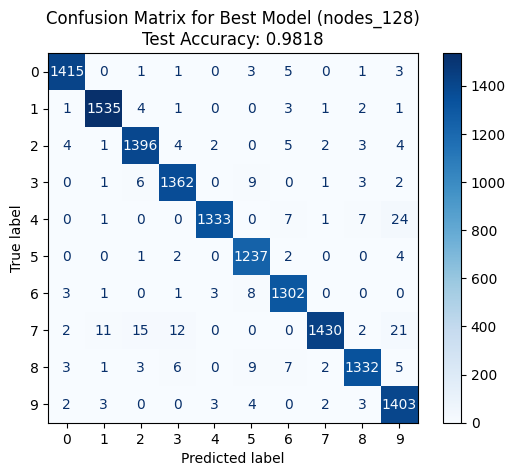

In [15]:
# Find the best model from both approaches
best_no_dropout = max(history_no_dropout.items(), 
                     key=lambda x: max(x[1].history['val_accuracy']))
best_with_dropout = max(history_with_dropout.items(), 
                       key=lambda x: max(x[1].history['val_accuracy']))

# Compare their validation accuracies
no_dropout_acc = max(best_no_dropout[1].history['val_accuracy'])
with_dropout_acc = max(best_with_dropout[1].history['val_accuracy'])

print("Best Model Comparison (Validation Accuracy):")
print(f"Without Dropout ({best_no_dropout[0]}): {no_dropout_acc:.4f}")
print(f"With Dropout ({best_with_dropout[0]}): {with_dropout_acc:.4f}")

# Select the overall best model
if no_dropout_acc > with_dropout_acc:
    best_config = best_no_dropout[0]
    best_model = best_no_dropout[1].model
    print("\nBest overall model: Without Dropout")
else:
    best_config = best_with_dropout[0]
    best_model = best_with_dropout[1].model
    print("\nBest overall model: With Dropout")

# Evaluate best model on test data
test_loss, test_accuracy = best_model.evaluate(x_test, y_test, verbose=1)

# Get predictions
y_pred = np.argmax(best_model.predict(x_test), axis=1)

# Print detailed results
print(f"\nBest Model Configuration: {best_config}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Plot confusion matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title(f'Confusion Matrix for Best Model ({best_config})\nTest Accuracy: {test_accuracy:.4f}')
plt.show()